# Nimbus Interactive Viewer
This notebook let's you view the the Pan-Multiplex dataset and it's gold-standard annottions in an interactive way.

In [1]:
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from nimbus_inference.nimbus import Nimbus, prep_naming_convention
from nimbus_inference.utils import MultiplexDataset, InteractiveDataset
from nimbus_inference.viewer_widget import NimbusInteractiveGTViewer
from nimbus_inference.example_dataset import download_and_unpack_gold_standard
from alpineer import io_utils
import pandas as pd
%matplotlib widget

C:\Users\lorenz\Desktop\angelo_lab\Nimbus-Inference\src\nimbus_inference\utils.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 0: Download the Pan-Multiplex gold-standard subset
The Pan-M dataset is a large dataset with over 100GB in images. To make it easier to view the annotations, we have created a subset of the dataset that only contains the FoVs that were manually annotated by experts. You can download this subset by running the following cells.

In [2]:
# Define the directory where you want to save the dataset
save_dir = "../data"

# Call the function to download and unpack the dataset
download_and_unpack_gold_standard(save_dir=save_dir, overwrite_existing=False)

In [3]:
# set up the base directory
base_dir = os.path.normpath("../data/gold_standard_labelled")

## 1: Load Pan-Multiplex dataset and annotations via the `MultiplexDataset` class
Next we will use the `MultiplexDataset` class to load the dataset and annotations. Then, the individual datasets are put into the `InteractiveDataset`, which allows for using the `NimbusInteractiveGTViewer` for interactive viewing of the data and annotations.

In [4]:
gt_df = pd.read_csv(os.path.join(base_dir, "gold_standard_groundtruth.csv"))

dataset_dict = {}
dsets = ['codex_colon', 'mibi_breast', 'mibi_decidua', 'vectra_colon', 'vectra_pancreas']
suffixes = ['.ome.tif', '.tiff', '.tif', '.ome.tif', '.ome.tif']

for dset, suffix in zip(dsets, suffixes):
    # prepare naming convetion
    dataset_path = os.path.join(base_dir, dset)
    fov_path = os.path.join(dataset_path, "fovs")
    fov_paths = [os.path.join(fov_path, f) for f in os.listdir(fov_path)]
    segmentation_dir = os.path.join(dataset_path, "masks")
    segmentation_naming_convention = prep_naming_convention(segmentation_dir, approx=True)
    # test segmentation_naming_convention
    if os.path.exists(segmentation_naming_convention(fov_paths[0])):
        print("Segmentation data exists for fov 0 and naming convention is correct")
    else:
        print("Segmentation data does not exist for fov 0 or naming convention is incorrect")
    # initialize MultiplexedDataset objects
    dataset = MultiplexDataset(
        fov_paths=fov_paths,
        suffix=suffix,
        include_channels=gt_df[gt_df['dataset'] == dset]['channel'].tolist(),
        segmentation_naming_convention=segmentation_naming_convention,
        groundtruth_df=gt_df[gt_df['dataset'] == dset],
        output_dir=dataset_path,
    )
    dataset_dict[dset] = dataset

datasets = InteractiveDataset(
    datasets=dataset_dict,
)

Segmentation data exists for fov 0 and naming convention is correct
All inputs are valid
Segmentation data exists for fov 0 and naming convention is correct
All inputs are valid
Segmentation data exists for fov 0 and naming convention is correct
All inputs are valid
Segmentation data exists for fov 0 and naming convention is correct
All inputs are valid
Segmentation data exists for fov 0 and naming convention is correct
All inputs are valid


## 2. Use the `NimbusInteractiveGTViewer` to explore the dataset and annotations
The `NimbusInteractiveGTViewer` class allows you to interactively view the dataset and annotations. You can zoom in and out of the images, pan around, and view the annotations on the right. The annotations are displayed with 100% pixel intensity for positive cells, 30% pixel intensity for ambiguous cells, and 0% pixel intensity for negative cells. Resize the viewer by dragging the triangle in the bottom right corner.

To zoom in and out of the images and pan around:

1. Click the cross icon on the left to enable image interaction mode.
2. To pan, right-click and drag the image.
3. To zoom, left-click on the image and drag up to zoom in or drag down to zoom out.

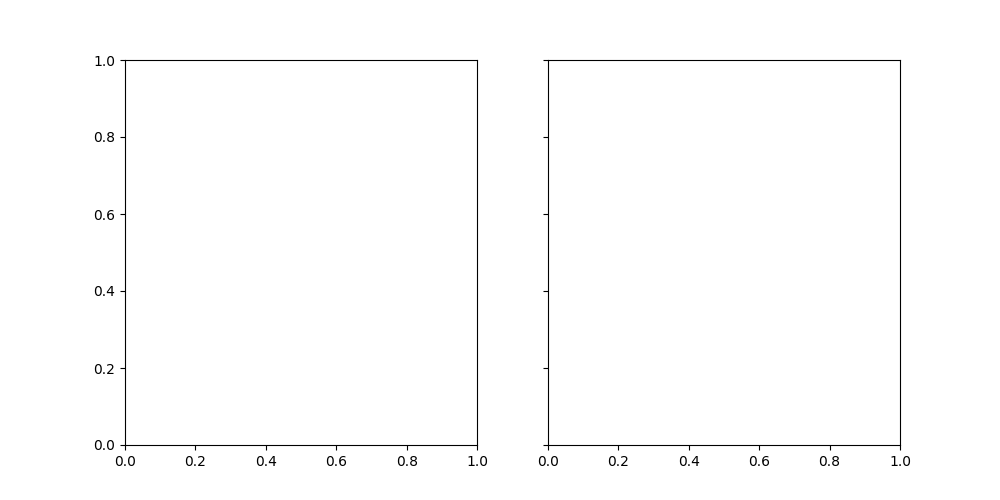

In [6]:
viewer = NimbusInteractiveGTViewer(
    datasets=datasets,
    output_dir=os.path.join(base_dir, "output"),
    figsize=(10, 5),
)
viewer.display()